In [1]:
import sys
sys.path.append("../src/")
sys.path.append("../src/AtomicT")

In [2]:
from AtomicH import elastic
from AtomicH import potentials
from AtomicH import constants
from AtomicH import spinexchange
from AtomicH import dipolelosses
import numpy as np
import pylab as plt
from AtomicH.dipolelosses import DipoleChannels
from AtomicH.spinexchange import SpinExChannels

In [3]:
k_A  = np.linspace(1e-4, 4*constants.hcInEVAngstrom, 200)
k_eV = k_A / constants.hcInEVAngstrom

r0       = 1e-9
intlimit = 100 * constants.BohrInAng/constants.hcInEVAngstrom
rhos     = np.linspace(r0, intlimit, 100)

muT = constants.TritiumConstants.mu

even_ls = np.arange(0, 16, 2)  

sigma_T_by_l = {}
sigma_T_total = np.zeros_like(k_A)  

for l in even_ls:
    sigma_T_partial = np.array([
        elastic.GetCrossSection(rhos, k, l, muT,
                                potentials.Silvera_Triplet, 'Radau')
        for k in k_A
    ])
    sigma_T_by_l[l] = sigma_T_partial
    sigma_T_total   += sigma_T_by_l[l]

In [4]:
def total_sigma_for_potential(pot_obj, k_grid_A, rhos, mu, integrator='Radau'):
    sigma_total = np.zeros_like(k_grid_A, dtype=float)
    for l in even_ls:
        
        sigma_l = np.array([elastic.GetCrossSection(rhos, k, l, mu, pot_obj, integrator)
            for k in k_grid_A])
        sigma_total += sigma_l
        
    return sigma_total

sigmaT_raw   = {}
sigmaT_ratio = {}

for pot_key, pot in potentials.Triplets.items():
    sigmaT_raw[pot_key] = total_sigma_for_potential(pot, k_A, rhos, muT)

for pot_key, sig in sigmaT_raw.items():
    sigmaT_ratio[pot_key] = sig / sigma_T_total

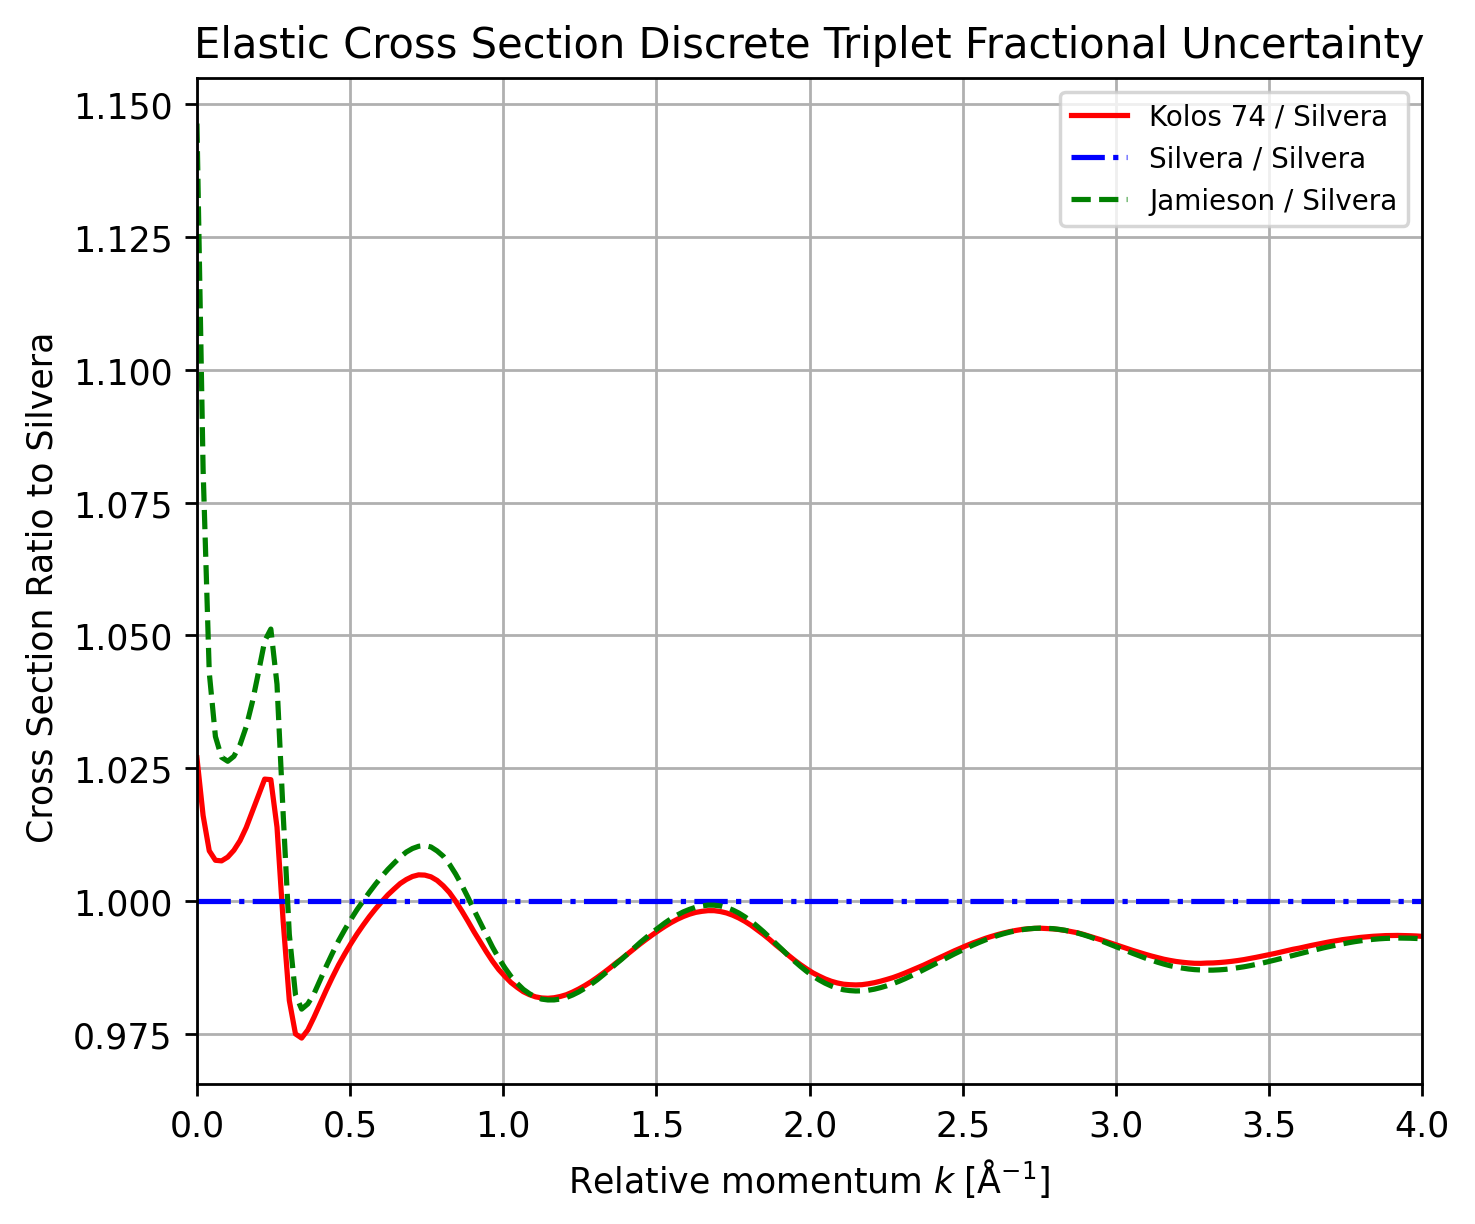

Kolos 74 / Silvera — mean ratio: 0.9927, std: 0.0084
Silvera / Silvera — mean ratio: 1.0000, std: 0.0000
Jamieson / Silvera — mean ratio: 0.9957, std: 0.0177


In [5]:
colors    = ['red', 'blue', 'green', 'orange', 'dimgrey', 'purple', 'brown', 'teal']
linetypes = ['-', '-.', '--', ':']

plt.figure(figsize=(6,5), dpi=250)
for i, pot_key in enumerate(potentials.Triplets.keys()):
    sig_ratio = sigmaT_ratio[pot_key]
    plt.plot(k_eV,sig_ratio,
        linetypes[i % len(linetypes)],color=colors[i % len(colors)],label=f"{pot_key} / {'Silvera'}")

plt.xlabel(r'Relative momentum $k\;[\mathrm{\AA}^{-1}]$')
plt.ylabel("Cross Section Ratio to Silvera ")
plt.xlim(0, 4)
plt.title("Elastic Cross Section Discrete Triplet Fractional Uncertainty")
plt.grid(True, which='both')
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

for pot_key in potentials.Triplets.keys():
    mean_ratio = float(np.mean(sigmaT_ratio[pot_key]))
    std_ratio  = float(np.std(sigmaT_ratio[pot_key]))
    print(f"{pot_key} / Silvera — mean ratio: {mean_ratio:.4f}, std: {std_ratio:.4f}")

In [6]:
def Potential_Perturbation(R):
    x = R * constants.hcInEVAngstrom / 4.16
    return (1 + .001*x) * potentials.Silvera_Triplet(R)

sigma_T_total_potential_perturb = total_sigma_for_potential(Potential_Perturbation, k_A, rhos, muT)

Mean ratio: 1.0014
Standard deviation: 0.0037


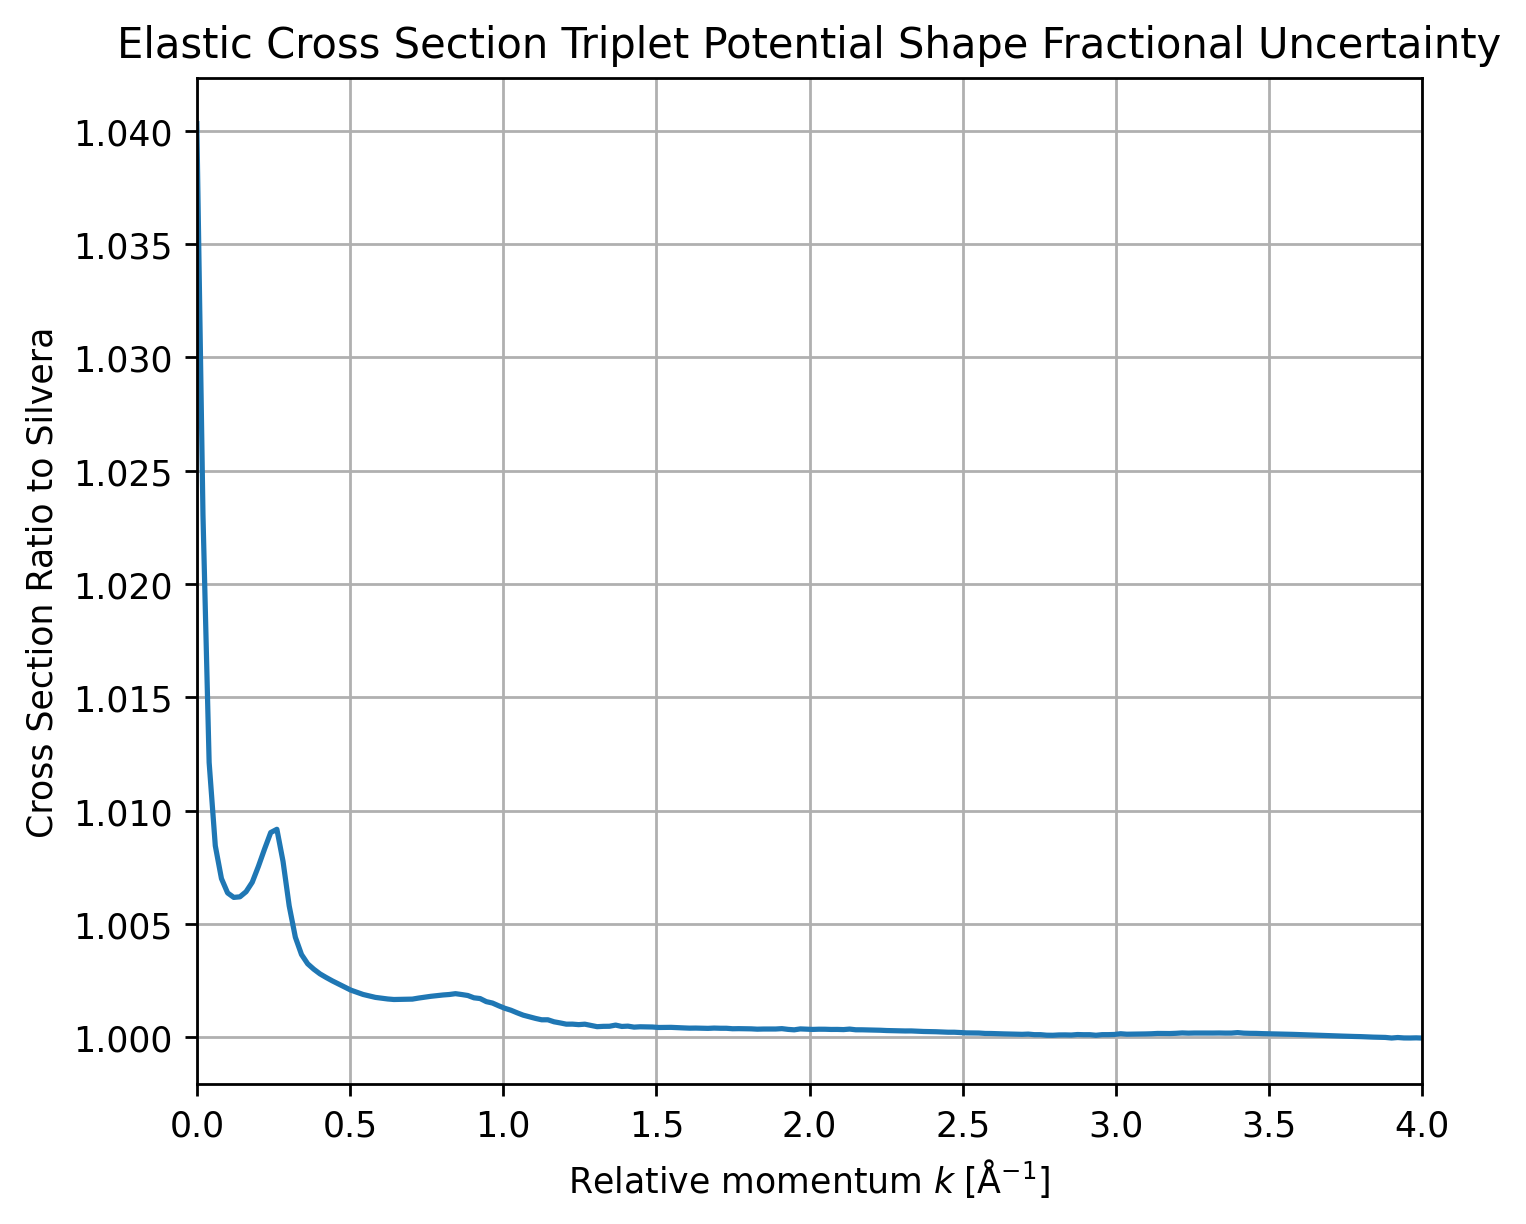

In [7]:
plt.figure(figsize=(6,5), dpi=250)
plt.plot(k_eV, sigma_T_total_potential_perturb / sigma_T_total)
plt.xlabel(r'Relative momentum $k\;[\mathrm{\AA}^{-1}]$')
plt.ylabel("Cross Section Ratio to Silvera")
plt.xlim(0, 4)
plt.title("Elastic Cross Section Triplet Potential Shape Fractional Uncertainty")
plt.grid(True, which='both')
plt.tight_layout()
plt.show

ratio = sigma_T_total_potential_perturb / sigma_T_total
mean_ratio = np.mean(ratio)
std_ratio  = np.std(ratio)

print(f"Mean ratio: {mean_ratio:.4f}")
print(f"Standard deviation: {std_ratio:.4f}")

In [8]:
sigmaT_raw_adiabatic = {}
sigmaT_ratio_adiabatic = {}

for pot_key, pot in potentials.TripletsT.items():
    sigmaT_raw_adiabatic[pot_key] = total_sigma_for_potential(pot, k_A, rhos, muT)

for pot_key in sigmaT_raw_adiabatic:
    sigmaT_ratio_adiabatic[pot_key] = sigmaT_raw_adiabatic[pot_key] / sigmaT_raw[pot_key]

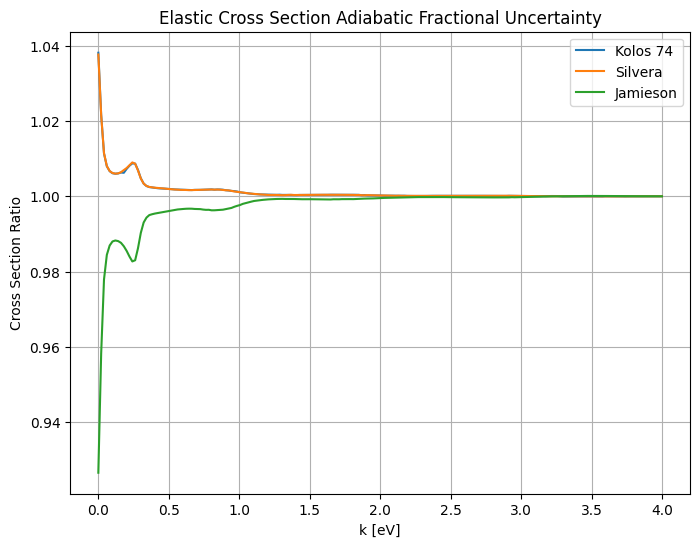

Kolos 74: mean = 1.0013, std = 0.0035
Silvera: mean = 1.0013, std = 0.0035
Jamieson: mean = 0.9975, std = 0.0069


In [9]:
plt.figure(figsize=(8,6))

for pot_key, ratio in sigmaT_ratio_adiabatic.items():
    plt.plot(k_eV, ratio, label=pot_key)

plt.xlabel("k [eV]")
plt.ylabel("Cross Section Ratio")
plt.title("Elastic Cross Section Adiabatic Fractional Uncertainty")
plt.legend()
plt.grid(True)
plt.show()

for pot_key, ratio in sigmaT_ratio_adiabatic.items():
    mean_ratio = np.mean(ratio)
    std_ratio  = np.std(ratio)
    print(f"{pot_key}: mean = {mean_ratio:.4f}, std = {std_ratio:.4f}")

In [10]:
extrapolation_potentials = {"Jamieson_Triplet_HFD": potentials.Jamieson_Triplet_HFD,
                            "Jamieson_Triplet_VDW": potentials.Jamieson_Triplet_VDW,}

sigmaT_raw_extrapolation = {}
sigmaT_ratio_extrapolation = {}

for pot_key, pot in extrapolation_potentials.items():
    sigmaT_raw_extrapolation[pot_key] = total_sigma_for_potential(pot, k_A, rhos, muT)

for pot_key, sigma_raw in sigmaT_raw_extrapolation.items():
    sigmaT_ratio_extrapolation[pot_key] = sigma_raw / sigmaT_raw_extrapolation["Jamieson_Triplet_HFD"]

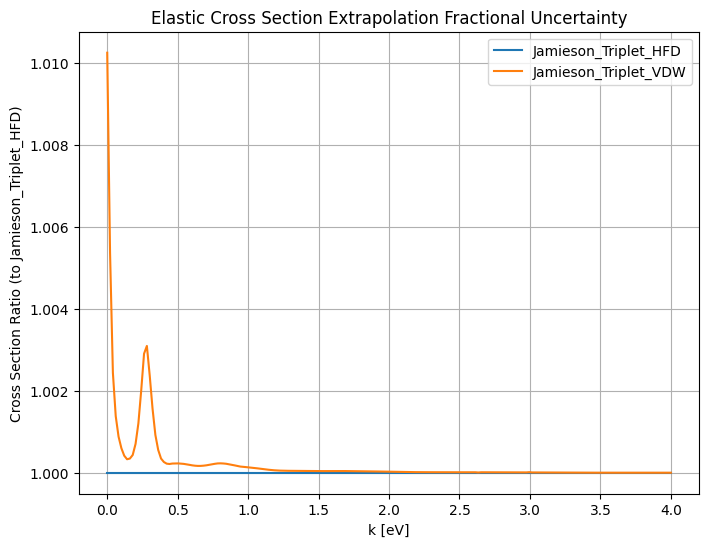

Jamieson_Triplet_HFD: mean = 1.0000, std = 0.0000
Jamieson_Triplet_VDW: mean = 1.0002, std = 0.0009


In [11]:
plt.figure(figsize=(8,6))
for pot_key, ratio in sigmaT_ratio_extrapolation.items():
    plt.plot(k_eV, ratio, label=pot_key)
plt.xlabel("k [eV]")
plt.ylabel("Cross Section Ratio (to Jamieson_Triplet_HFD)")
plt.title("Elastic Cross Section Extrapolation Fractional Uncertainty")
plt.legend()
plt.grid(True)
plt.show()

for pot_key, ratio in sigmaT_ratio_extrapolation.items():
    mean_ratio = np.mean(ratio)
    std_ratio = np.std(ratio)
    print(f"{pot_key}: mean = {mean_ratio:.4f}, std = {std_ratio:.4f}")

In [12]:
amuT = constants.TritiumConstants.mu + constants.meeV/2
sigmaT_raw_atomic = total_sigma_for_potential(pot, k_A, rhos, amuT)
sigmaT_ratio_atomic = sigmaT_raw_atomic / sigma_T_total

/var/folders/x8/m88g9m690wb3gf4t7ds85nzw0000gn/T/ipykernel_22699/899510961.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


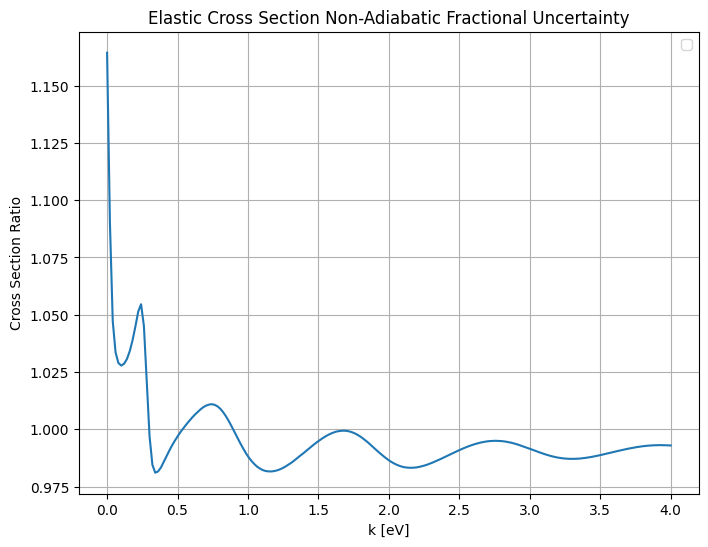

σT_ratio_atomic: mean = 0.9961, std = 0.0190


In [13]:
plt.figure(figsize=(8,6))
plt.plot(k_eV, sigmaT_ratio_atomic)
plt.xlabel("k [eV]")
plt.ylabel("Cross Section Ratio")
plt.title("Elastic Cross Section Non-Adiabatic Fractional Uncertainty")
plt.legend()
plt.grid(True)
plt.show()

mean_val = np.mean(sigmaT_ratio_atomic)
std_val  = np.std(sigmaT_ratio_atomic)

print(f"σT_ratio_atomic: mean = {mean_val:.4f}, std = {std_val:.4f}")

In [14]:
potT = potentials.Silvera_Triplet

B_values = np.linspace(0.001, 0.1, 10)
T = 5e-4
rhos = np.linspace(1e-9, 0.75, 2000)

G_factors_rawDip = {}
G_factor_ratiosDip = {}

base_key = "Silvera"
base_potential = potentials.Triplets[base_key]


base_losses_by_channel = {}
for c in DipoleChannels:
    base_losses_by_channel[str(c)] = np.array([dipolelosses.GetGFactor(c, B, constants.TritiumConstants(), T, base_potential, rhos)for B in B_values])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [ ]:
for pot_key, pot in potentials.Triplets.items():
    G_factors_rawDip[pot_key] = {}
    G_factor_ratiosDip[pot_key] = {}

    for c in DipoleChannels:
        channel_str = str(c)
        losses = np.array([dipolelosses.GetGFactor(c, B, constants.TritiumConstants(), T, pot, rhos)for B in B_values])
        G_factors_rawDip[pot_key][channel_str] = losses
        G_factor_ratiosDip[pot_key][channel_str] = losses / base_losses_by_channel[channel_str]

In [ ]:
colors = ['red', 'blue', 'green', 'orange', 'dimgrey']
linetypes = ['-', '-.', '--', ':']

for pi, pot_key in enumerate(potentials.Triplets.keys()):
    print(f"\n=== {pot_key} / {base_key} (Dipole) ===")
    plt.figure(figsize=(5, 5), dpi=150)

    for ci, c in enumerate(DipoleChannels):
        channel_str = str(c)
        ratios = np.asarray(G_factor_ratiosDip[pot_key][channel_str], dtype=float)
        ratios[~np.isfinite(ratios)] = np.nan  

        mean_ratio = np.nanmean(ratios)
        std_ratio  = np.nanstd(ratios)

        print(f"Channel {ci+1} ({channel_str}): "f"mean = {mean_ratio:.4f}, std = {std_ratio:.4f}")

        label = f"Channel {ci+1}" if pi == 0 else None  
        plt.plot(B_values,ratios,
                 linetypes[pi % len(linetypes)],
                 color=colors[ci % len(colors)],
                 label=label)

    plt.xlabel("B (T)")
    plt.ylabel(f"Ratio to {base_key} $G(B)$")
    plt.title(f"Loss Rate Ratios: {pot_key} vs {base_key}")
    plt.grid(True, which='both')
    plt.legend(title="Dipole Channels", fontsize=8)
    plt.tight_layout()
    plt.show()

In [ ]:
label = 'Dip_Trip'  
G_factors_raw_perturb   = {label: {}}   
G_factor_ratios_perturb = {label: {}}   

for c in DipoleChannels:
    channel_str = str(c)
    losses = np.asarray([
        dipolelosses.GetGFactor(c, B, constants.TritiumConstants(), T,Potential_Perturbation, rhos, lin=0, lout=2)
            for B in B_values], dtype=float)

    G_factors_raw_perturb[label][channel_str]   = losses
    G_factor_ratios_perturb[label][channel_str] = losses / base_losses_by_channel[channel_str]


In [ ]:
print(f"\n=== {label}: Potential_Perturbation / Base (Dipole) ===")
for i, (channel_str, ratio_obj) in enumerate(G_factor_ratios_perturb[label].items(), start=1):
    ratios = np.asarray(ratio_obj, dtype=float)
    ratios[~np.isfinite(ratios)] = np.nan  

    mean_ratio = np.nanmean(ratios)
    std_ratio  = np.nanstd(ratios)
    print(f"Channel {i} ({channel_str}): mean = {mean_ratio:.4f}, std = {std_ratio:.4f}")

plt.figure(figsize=(6,5), dpi=150)
for i, (channel_str, ratio_obj) in enumerate(G_factor_ratios_perturb[label].items(), start=1):
    ratios = np.asarray(ratio_obj, dtype=float)
    ratios[~np.isfinite(ratios)] = np.nan
    plt.plot(
        B_values, ratios,
        linestyle=linetypes[i % len(linetypes)],
        color=colors[i % len(colors)],
        label=f"Channel {channel_str}"
    )

plt.xlabel("B (T)")
plt.ylabel("G (perturbed) / G (base)")
plt.title(f"Dipole Loss Ratio: {label} vs Base")
plt.grid(True, which='both')
#plt.legend(title="Dipole Channels", fontsize=8, ncol=2)
plt.tight_layout()
plt.show()


In [ ]:
G_factors_raw_adiabaticDip = {}
G_factor_ratios_adiabaticDip = {}

for pot_key, pot in potentials.TripletsT.items():
    G_factors_raw_adiabaticDip[pot_key] = {}
    G_factor_ratios_adiabaticDip[pot_key] = {}

    for c in DipoleChannels:
        channel_str = str(c)
        losses = np.array([dipolelosses.GetGFactor(c, B, constants.TritiumConstants(), T, pot, rhos)for B in B_values])
        G_factors_raw_adiabaticDip[pot_key][channel_str] = losses
        G_factor_ratios_adiabaticDip[pot_key][channel_str] = losses / G_factors_rawDip[pot_key][channel_str]

In [ ]:
colors = ['red', 'blue', 'green', 'orange', 'dimgrey']
linetypes = ['-', '-.', '--', ':']

for pi, pot_key in enumerate(potentials.TripletsT.keys()):
    print(f"\n=== {pot_key} / {base_key} (Dipole) ===")
    plt.figure(figsize=(5, 5), dpi=150)

    for ci, c in enumerate(DipoleChannels):
        channel_str = str(c)
        ratios = np.asarray(G_factor_ratios_adiabaticDip[pot_key][channel_str], dtype=float)
        ratios[~np.isfinite(ratios)] = np.nan 

        mean_ratio = np.nanmean(ratios)
        std_ratio  = np.nanstd(ratios)
        print(f"Channel {ci+1} ({channel_str}): mean = {mean_ratio:.4f}, std = {std_ratio:.4f}")

        label = f"Channel {ci+1}" if pi == 0 else None  
        plt.plot(B_values, ratios,
                 linetypes[pi % len(linetypes)],
                 color=colors[ci % len(colors)],
                 label=label)
    plt.xlabel("B (T)")
    plt.ylabel(f"Ratio to {base_key} $G(B)$")
    plt.title(f"Loss Rate Ratios: {pot_key} vs {base_key}")
    plt.grid(True, which='both')
    plt.legend(title="Dipole Channels", fontsize=8)
    plt.tight_layout()
    plt.show()

In [ ]:
pots = {"Jamieson_Triplet_VDW": potentials.Jamieson_Triplet_VDW,
        "Jamieson_Triplet_HFD": potentials.Jamieson_Triplet_HFD}

G_factors_raw_two = {k: {} for k in pots.keys()}

for pot_key, pot in pots.items():
    for c in DipoleChannels:
        channel_str = str(c)
        losses = np.asarray([
            dipolelosses.GetGFactor(c, B, constants.TritiumConstants(), T, pot, rhos)
            for B in B_values], dtype=float)
        
        G_factors_raw_two[pot_key][channel_str] = losses

ratio_VDW_over_HFD = {}
for c in DipoleChannels:
    channel_str = str(c)
    num = G_factors_raw_two["Jamieson_Triplet_VDW"][channel_str]
    den = G_factors_raw_two["Jamieson_Triplet_HFD"][channel_str]
    ratio = num / den
    ratio_VDW_over_HFD[channel_str] = ratio

In [ ]:
print("\n=== Dipole Loss Ratio: Jamieson_Triplet_VDW / Jamieson_Triplet_HFD ===")
for i, c in enumerate(DipoleChannels, start=1):
    channel_str = str(c)
    r = ratio_VDW_over_HFD[channel_str]
    mean_r = float(np.mean(r))
    std_r  = float(np.std(r))
    print(f"Channel {i} ({channel_str}): mean = {mean_r:.4f}, std = {std_r:.4f}")
    
plt.figure(figsize=(6,5), dpi=150)
for i, c in enumerate(DipoleChannels):
    channel_str = str(c)
    plt.plot(B_values,ratio_VDW_over_HFD[channel_str],
             linetypes[i % len(linetypes)],
             color=colors[i % len(colors)],
             label=f"Channel {channel_str}")

plt.xlabel("B (T)")
plt.ylabel("G (perturbed) / G (original)")
plt.title("G-factor Ratio: Perturbed nm / Original nm")
plt.grid(True, which="both")
plt.legend(title="Dipole Channels", fontsize=8)
plt.tight_layout()
plt.show()

In [ ]:
def get_perturbed_resultsDip(attr_name, delta):
    consts = constants.TritiumConstants()
    orig_val = getattr(consts, attr_name)
    setattr(consts, attr_name, orig_val + delta)
    results = {}
    for c in DipoleChannels:
        Gs = []
        for B in B_values:
            Gs.append(
                dipolelosses.GetGFactor(c, B, consts, T, potentials.Silvera_Triplet, rhos,
                    lin=0, lout=2))
        results[str(c)] = np.array(Gs)

    return results
attr_to_perturb = "mu"                 
delta_value = constants.meeV / 2   
G_perturbed = get_perturbed_resultsDip(attr_to_perturb, delta_value)

original = G_factors_rawDip["Silvera"]

In [ ]:
ratio_vs_unperturbed = {}

for channel_str in original.keys():
    unperturbed = np.asarray(original[channel_str], dtype=float)
    perturbed   = np.asarray(G_perturbed[channel_str], dtype=float)

    ratio = perturbed / unperturbed
    ratio_vs_unperturbed[channel_str] = ratio

    mean_ratio = np.nanmean(ratio)
    std_ratio  = np.nanstd(ratio)
    print(f"Channel {channel_str}: mean = {mean_ratio:.4f}, std = {std_ratio:.4f}")

plt.figure(figsize=(6, 5), dpi=150)
for i, (channel_str, ratio) in enumerate(ratio_vs_unperturbed.items()):
    plt.plot(B_values, ratio,
             label=f"Channel {channel_str}",
             linestyle=linetypes[i % len(linetypes)],
             color=colors[i % len(colors)])

plt.xlabel("B (T)")
plt.ylabel("G (perturbed) / G (original)")
plt.title("G-factor Ratio: Perturbed nm / Original nm")
plt.grid(True, which="both")
plt.legend(title="Dipole Channels", fontsize=8)
plt.tight_layout()
plt.show()


In [ ]:
potS = potentials.Kolos_Singlet2_VDW

G_factors_raw_SETrip = {}
G_factor_ratios_SETrip = {}

base_key = "Silvera"
base_potential = potentials.Triplets[base_key]

base_losses_by_channel = {}
for c in SpinExChannels:
    channel_str = str(c)
    base_losses_by_channel[channel_str] = np.array([spinexchange.GetGFactor(c, B, constants.TritiumConstants(), T, base_potential, potS, rhos)
        for B in B_values])

for pot_key, potT in potentials.Triplets.items():
    G_factors_raw_SETrip[pot_key] = {}
    G_factor_ratios_SETrip[pot_key] = {}

    for c in SpinExChannels:
        channel_str = str(c)
        losses = np.array([spinexchange.GetGFactor(c, B, constants.TritiumConstants(), T, potT, potS, rhos)
            for B in B_values])

        G_factors_raw_SETrip[pot_key][channel_str] = losses
        G_factor_ratios_SETrip[pot_key][channel_str] = losses / base_losses_by_channel[channel_str]

In [ ]:
for pi, pot_key in enumerate(potentials.Triplets.keys()):
    print(f"\n=== {pot_key} / {base_key} ===")
    plt.figure(figsize=(5, 5), dpi=150)

    for ci, c in enumerate(SpinExChannels):
        channel_str = str(c)
        ratios = np.asarray(G_factor_ratios_SETrip[pot_key][channel_str], dtype=float)
        mean_ratio = np.nanmean(ratios)
        std_ratio  = np.nanstd(ratios)
        print(f"Channel {ci+1} ({channel_str}): mean = {mean_ratio:.4f}, std = {std_ratio:.4f}")
        
        label = f"Channel {ci+1}" if pi == 1 else None  
        plt.plot(B_values,ratios,
                 linetypes[pi % len(linetypes)],
                 color=colors[ci % len(colors)],
                 label=label)

    plt.xlabel("B (T)")
    plt.xlim(0.001, 10)
    plt.ylabel(f"Ratio to {base_key} $G(B)$")
    plt.title(f"Spin Exchange Ratio: {pot_key} / {base_key}")
    plt.grid(True, which='both')
    plt.legend(title="SpinEx Channels", fontsize=8)
    plt.tight_layout()
    plt.show()

In [ ]:
potT = potentials.Silvera_Triplet

G_factors_raw_SESing   = {}
G_factor_ratios_SESing = {}

base_key       = "Kolos 74"
base_potential = potentials.Singlets[base_key]

base_losses_by_channel = {}
for c in SpinExChannels:
    ch = str(c)
    base_losses_by_channel[ch] = np.asarray([
        spinexchange.GetGFactor(c, B, constants.TritiumConstants(), T, potT, base_potential, rhos)
        for B in B_values
    ], dtype=float)

for pot_key, potS in potentials.Singlets.items():
    G_factors_raw_SESing[pot_key]   = {}
    G_factor_ratios_SESing[pot_key] = {}

    for c in SpinExChannels:
        ch = str(c)
        losses = np.asarray([spinexchange.GetGFactor(c, B, constants.TritiumConstants(), T, potT, potS, rhos)
                             for B in B_values], dtype=float)

        G_factors_raw_SESing[pot_key][ch]   = losses
        G_factor_ratios_SESing[pot_key][ch] = losses / base_losses_by_channel[ch]

In [ ]:
for pi, (pot_key, ch_map) in enumerate(G_factor_ratios_SESing.items()):
    print(f"\n=== {pot_key} / {base_key} ===")
    plt.figure(figsize=(5, 5), dpi=150)

    for ci, c in enumerate(SpinExChannels):
        channel_str = str(c)
        ratios = np.asarray(ch_map[channel_str], dtype=float)

        mean_ratio = np.mean(ratios)
        std_ratio  = np.std(ratios)

        print(f"Channel {ci+1} ({channel_str}): mean = {mean_ratio:.4f}, std = {std_ratio:.4f}")

        label = f"Channel {ci+1}" if pi == 0 else None
        plt.plot(
            B_values,
            ratios,
            linetypes[pi % len(linetypes)],
            color=colors[ci % len(colors)],
            label=label
        )

    plt.xlabel("B (T)")
    plt.xlim(0.001, 10)
    plt.ylabel(f"Ratio to {base_key} $G(B)$")
    plt.title(f"Spin Exchange Ratio: {pot_key} / {base_key}")
    plt.grid(True, which='both')
    plt.legend(title="SpinEx Channels", fontsize=8)
    plt.tight_layout()
    plt.show()


In [ ]:
label_pert = "Potential_Perturbation"
G_factors_raw_SETrip[label_pert] = {}
G_factor_ratios_SETrip[label_pert] = {}

for c in SpinExChannels:
    ch = str(c)
    pert_losses = np.array([
        spinexchange.GetGFactor(c, B, constants.TritiumConstants(), T,
                                Potential_Perturbation, potS, rhos)
        for B in B_values
    ])
    G_factors_raw_SETrip[label_pert][ch] = pert_losses
    base_losses = base_losses_by_channel[ch]
    ratio = base_losses / pert_losses
    G_factor_ratios_SETrip[label_pert][ch] = ratio

In [ ]:
print(f"\n=== Silvera / {label_pert} ===")
plt.figure(figsize=(6, 5), dpi=150)

for i, c in enumerate(SpinExChannels, start=1):
    ch = str(c)

    r = np.asarray(G_factor_ratios_SETrip[label_pert][ch], dtype=float)
    r[~np.isfinite(r)] = np.nan

    mean_r = float(np.nanmean(r))
    std_r  = float(np.nanstd(r))
    print(f"Channel {i} ({ch}): mean = {mean_r:.4f}, std = {std_r:.4f}")

    plt.plot(B_values, r,
             linetypes[i % len(linetypes)],
             color=colors[i % len(colors)],
             label=f"Channel {i}")

plt.xlabel("B (T)")
plt.xlim(0.001, 10)
plt.ylabel(f"G(Silvera) / G({label_pert})")
plt.title(f"Spin Exchange Ratio: Silvera relative to {label_pert}")
plt.grid(True, which="both")
plt.legend(title="SpinEx Channels", fontsize=8, ncol=2)
plt.tight_layout()
plt.show()


In [ ]:
def Singlet_Perturbation(R):
    x = R * constants.hcInEVAngstrom / 4.16
    return (1 + .001*x) * potentials.Jamieson_Singlet_VDW(R)

In [ ]:
potT = potentials.Silvera_Triplet
label_pert = "Singlet_Perturbation"   
singlet_pert = Singlet_Perturbation

base_key = "Jamieson"

G_factors_raw_SESing[label_pert]   = {}
G_factor_ratios_SESing[label_pert] = {}

for c in SpinExChannels:
    ch = str(c)
    losses = np.asarray([spinexchange.GetGFactor(c, B, constants.TritiumConstants(), T, potT, singlet_pert, rhos)
                         for B in B_values], dtype=float)

    G_factors_raw_SESing[label_pert][ch]   = losses
    G_factor_ratios_SESing[label_pert][ch] = losses / G_factors_raw_SESing[base_key][ch]


In [ ]:
print(f"\n=== {label_pert} / {base_key} ===")
plt.figure(figsize=(6, 5), dpi=150)

for i, c in enumerate(SpinExChannels, start=1):
    ch = str(c)
    r = np.asarray(G_factor_ratios_SESing[label_pert][ch], dtype=float)
    r[~np.isfinite(r)] = np.nan

    mean_r = float(np.nanmean(r))
    std_r  = float(np.nanstd(r))
    print(f"Channel {i} ({ch}): mean = {mean_r:.4f}, std = {std_r:.4f}")

    plt.plot(B_values, r,
             linetypes[i % len(linetypes)],
             color=colors[i % len(colors)],
             label=f"Channel {i}")

plt.xlabel("B (T)")
plt.xlim(0.001, 10)
plt.ylabel(f"G({label_pert}) / G({base_key})")
plt.title(f"Spin Exchange Ratio: {label_pert} relative to {base_key}")
plt.grid(True, which="both")
plt.legend(title="SpinEx Channels", fontsize=8, ncol=2)
plt.tight_layout()
plt.show()

In [ ]:
def get_perturbed_resultsEx(attr_name, delta):
    consts = constants.TritiumConstants()
    orig_val = getattr(consts, attr_name)
    setattr(consts, attr_name, orig_val + delta)

    results = {}
    for c in SpinExChannels:
        Gs = []
        for B in B_values:
            Gs.append(spinexchange.GetGFactor(c, B, consts, T,
                                              potentials.Silvera_Triplet,
                                              potentials.Kolos_Singlet2_VDW,
                                              rhos))
        results[str(c)] = np.asarray(Gs, dtype=float)     
    return results

attr_to_perturb = "mu"
delta_value     = constants.meeV / 2
G_perturbedEx   = get_perturbed_resultsEx(attr_to_perturb, delta_value)


In [ ]:
ratio_vs_unperturbedEx = {}

originalEx = G_factors_raw_SESing["Kolos 74"]   
for ch in originalEx.keys():
    unperturbed = np.asarray(originalEx[ch], dtype=float)
    perturbed   = np.asarray(G_perturbedEx[ch], dtype=float)
    ratio       = perturbed / unperturbed
    ratio_vs_unperturbedEx[ch] = ratio

    mean_ratio = float(np.nanmean(ratio))
    std_ratio  = float(np.nanstd(ratio))
    print(f"Channel {ch}: mean = {mean_ratio:.4f}, std = {std_ratio:.4f}")

plt.figure(figsize=(6, 5), dpi=150)
for i, (ch, ratio) in enumerate(ratio_vs_unperturbedEx.items()):
    plt.plot(B_values, ratio,
             label=f"Channel {ch}",
             linestyle=linetypes[i % len(linetypes)],
             color=colors[i % len(colors)])

plt.xlabel("B (T)")
plt.ylabel("G (perturbed) / G (original)")
plt.title("Spin Exchange G-factor Ratio: Perturbed nm / Original nm")
plt.grid(True, which="both")
#plt.legend(title="SpinEx Channels", fontsize=8, ncol=2)
plt.tight_layout()
plt.show()


In [ ]:
potS = potentials.Kolos_Singlet2_VDW

G_factors_raw_adiabaticTrip = {}
G_factor_ratios_adiabaticTrip = {}

for pot_key, potT in potentials.TripletsT.items():
    G_factors_raw_adiabaticTrip[pot_key] = {}
    G_factor_ratios_adiabaticTrip[pot_key] = {}

    for c in SpinExChannels:
        channel_str = str(c)
        losses = np.array([spinexchange.GetGFactor(c, B, constants.TritiumConstants(), T, potT, potS, rhos)
            for B in B_values])

        G_factors_raw_adiabaticTrip[pot_key][channel_str] = losses
        G_factor_ratios_adiabaticTrip[pot_key][channel_str] = losses / G_factors_raw_SETrip[pot_key][channel_str]

In [ ]:
for pi, pot_key in enumerate(G_factor_ratios_adiabaticTrip.keys()):
    print(f"\n=== {pot_key} (adiabatic / non-adiabatic) ===")
    plt.figure(figsize=(5, 5), dpi=150)

    for ci, c in enumerate(SpinExChannels):
        channel_str = str(c)

        ratios = np.asarray(G_factor_ratios_adiabaticTrip[pot_key][channel_str], dtype=float)
        ratios[~np.isfinite(ratios)] = np.nan  
        mean_ratio = float(np.nanmean(ratios))
        std_ratio  = float(np.nanstd(ratios))
        print(f"Channel {ci+1} ({channel_str}): mean = {mean_ratio:.4f}, std = {std_ratio:.4f}")

        label = f"Channel {ci+1}" if pi == 0 else None
        plt.plot(B_values,ratios,
                 linetypes[pi % len(linetypes)],
                 color=colors[ci % len(colors)],
                 label=label)

    plt.xlabel("B (T)")
    plt.xlim(0.001, 10)
    plt.ylabel("Cross Section Ratio (adiabatic / non-adiabatic)")
    plt.title(f"Spin Exchange (Triplet {pot_key}) — Adiabatic Fractional Change")
    plt.grid(True, which='both')
    plt.legend(title="SpinEx Channels", fontsize=8, ncol=2)
    plt.tight_layout()
    plt.show()


In [ ]:
potT = potentials.Silvera_Triplet

G_factors_raw_adiabaticSing   = {}
G_factor_ratios_adiabaticSing = {}

for pot_key, potS in potentials.SingletsT.items():
    G_factors_raw_adiabaticSing[pot_key]   = {}
    G_factor_ratios_adiabaticSing[pot_key] = {}

    for c in SpinExChannels:
        ch = str(c)
        losses = np.asarray([spinexchange.GetGFactor(c, B, constants.TritiumConstants(), T, potT, potS, rhos)
                             for B in B_values], dtype=float)

        G_factors_raw_adiabaticSing[pot_key][ch]   = losses
        G_factor_ratios_adiabaticSing[pot_key][ch] = losses / G_factors_raw_SESing[pot_key][ch]

In [ ]:
for pi, pot_key in enumerate(G_factor_ratios_adiabaticSing.keys()):
    print(f"\n=== {pot_key} (adiabatic / non-adiabatic, Singlet) ===")
    plt.figure(figsize=(5, 5), dpi=150)

    for ci, c in enumerate(SpinExChannels):
        ch = str(c)
        ratios = np.asarray(G_factor_ratios_adiabaticSing[pot_key][ch], dtype=float)
        ratios[~np.isfinite(ratios)] = np.nan  

        mean_ratio = float(np.nanmean(ratios))
        std_ratio  = float(np.nanstd(ratios))
        print(f"Channel {ci+1} ({ch}): mean = {mean_ratio:.4f}, std = {std_ratio:.4f}")

        label = f"Channel {ci+1}" if pi == 0 else None
        plt.plot(B_values, ratios,
                 linetypes[pi % len(linetypes)],
                 color=colors[ci % len(colors)],
                 label=label)

    plt.xlabel("B (T)")
    plt.xlim(0.001, 10)
    plt.ylabel("Cross Section Ratio (adiabatic / non-adiabatic)")
    plt.title(f"Spin Exchange (Singlet {pot_key}) — Adiabatic Fractional Change")
    plt.grid(True, which='both')
    plt.legend(title="SpinEx Channels", fontsize=8, ncol=2)
    plt.tight_layout()
    plt.show()


In [ ]:
potS = potentials.Kolos_Singlet2_VDW

G_factors_raw_trip_extrap   = {}
G_factor_ratios_trip_extrap = {}

num_key = "Jamieson_Triplet_VDW"
den_key = "Jamieson"
G_factors_raw_trip_extrap[num_key] = {}
for c in SpinExChannels:
    ch = str(c)
    vals = [spinexchange.GetGFactor(c, B, constants.TritiumConstants(), T,
                                    potentials.Jamieson_Triplet_VDW, potS, rhos)
            for B in B_values]
    G_factors_raw_trip_extrap[num_key][ch] = np.asarray(vals, dtype=float)

G_factor_ratios_trip_extrap["VDW"] = {}
for c in SpinExChannels:
    ch = str(c)
    num = np.asarray(G_factors_raw_trip_extrap[num_key][ch], dtype=float)
    den = np.asarray(G_factors_raw_SETrip[den_key][ch], dtype=float)  
    ratio = num / den
    G_factor_ratios_trip_extrap["VDW"][ch] = ratio

In [ ]:
print("\n=== Jamieson_Triplet_VDW / Jamieson (Spin-exchange) ===")
plt.figure(figsize=(6,5), dpi=150)
for i, c in enumerate(SpinExChannels, start=1):
    ch = str(c)
    r = np.asarray(G_factor_ratios_trip_extrap["VDW"][ch], dtype=float)
    r[~np.isfinite(r)] = np.nan

    mean_r = float(np.nanmean(r))
    std_r  = float(np.nanstd(r))
    print(f"Channel {i} ({ch}): mean = {mean_r:.4f}, std = {std_r:.4f}")

    plt.plot(B_values, r,
             linetypes[i % len(linetypes)],
             color=colors[i % len(colors)],
             label=f"Channel {i}")

plt.xlabel("B (T)")
plt.xlim(0.001, 10)
plt.ylabel("G(Jamieson_Triplet_VDW) / G(Jamieson)")
plt.title("Spin Exchange Ratio: Jamieson VDW vs Jamieson")
plt.grid(True, which='both')
plt.legend(title="SpinEx Channels", fontsize=8, ncol=2)
plt.tight_layout()
plt.show()